In [1]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from pyESN import ESN
# 기술적 지표 모듈 (*** MACD, BB, RSI 조합으로 수정 ***)
# import MovingAverage as ma  # MA는 사용 안 함
import MACD as macd
import RSI2 as rsi           # RSI -> RSI2
import CPM2 as cpm           # Cpm -> CPM2
import BollingerBands2 as bb # (*** BB2 추가 ***)
import CV_ESN3 as CV_ESN     # (*** CV_ESN3 임포트 ***)
import ESN_Signals           # (ESN 헬퍼)
import eval_signal3          # (GA 피트니스 헬퍼)

# 모듈 리로드 (코드 수정 시 즉시 반영용)
import importlib
# importlib.reload(ma) # MA는 사용 안 함
importlib.reload(macd)
importlib.reload(rsi)
importlib.reload(cpm)
importlib.reload(bb)         # (*** BB2 추가 ***)
importlib.reload(CV_ESN)     # (*** CV_ESN3 추가 ***)
importlib.reload(ESN_Signals)
importlib.reload(eval_signal3)


c:\Users\kki69\AppData\Local\Programs\Python\Python311\Lib\site-packages\backtesting\_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

<module 'eval_signal3' from 'c:\\Users\\kki69\\Desktop\\New Capstone\\eval_signal3.py'>

In [2]:
name = 'TSLA' 
ticker = yf.Ticker(name)
ori_df = ticker.history(start='2015-07-22', end='2025-07-22', interval='1d', auto_adjust=True)

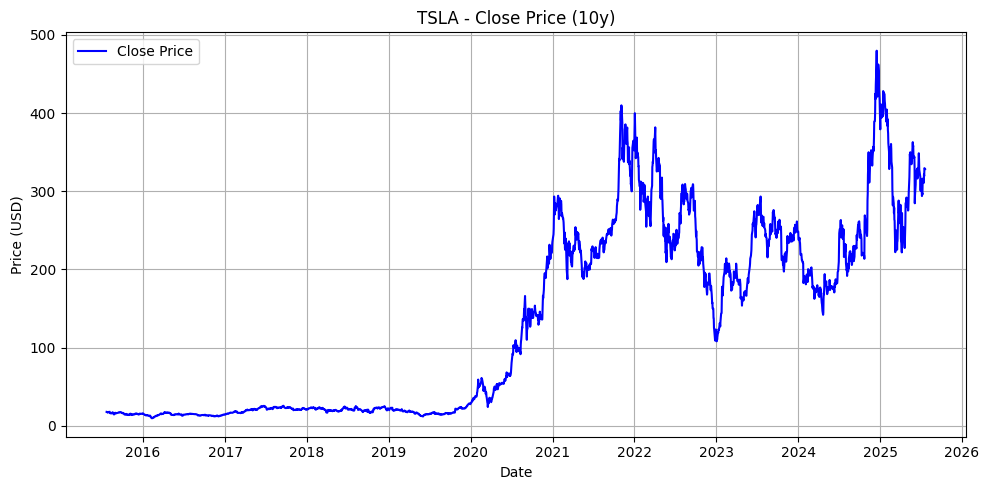

In [3]:
plt.figure(figsize=(10, 5))
plt.plot(ori_df.index, ori_df['Close'], label='Close Price', color='blue')
plt.title(f'{name} - Close Price (10y)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
df = ori_df.copy()

In [5]:
cpm_points, df_with_cpm = cpm.cpm_model(df, column='Close',P=0.05, T=5)

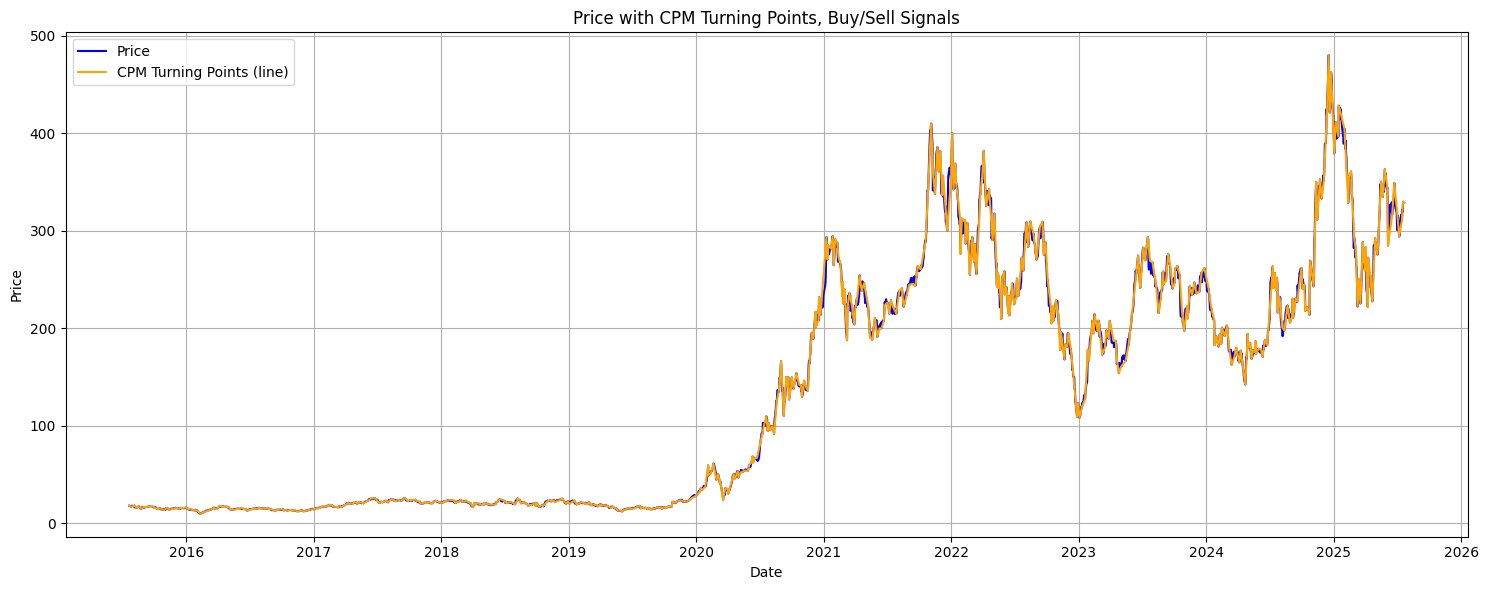

In [6]:
# CPM 신호가 있는 인덱스와 가격
cpm_indices = df_with_cpm[df_with_cpm['is_cpm_point'] == True].index
cpm_prices = df_with_cpm.loc[cpm_indices, 'Close']

# Buy (1) / Sell (-1) 인덱스와 가격
buy_indices = df_with_cpm[df_with_cpm['cpm_point_type'] == 1].index
sell_indices = df_with_cpm[df_with_cpm['cpm_point_type'] == -1].index
buy_prices = df_with_cpm.loc[buy_indices, 'Close']
sell_prices = df_with_cpm.loc[sell_indices, 'Close']

plt.figure(figsize=(15, 6))

# 1. 전체 가격 라인
plt.plot(df.index, df_with_cpm['Close'], label='Price', color='blue')

# 2. CPM 전환점을 선으로 연결
plt.plot(cpm_indices, cpm_prices, label='CPM Turning Points (line)', color='orange')

# 3. Buy 시점 (▲ 초록색)
#plt.scatter(buy_indices, buy_prices, label='Buy Signal', marker='^', color='green', s=100)

# 4. Sell 시점 (▼ 빨간색)
#plt.scatter(sell_indices, sell_prices, label='Sell Signal', marker='v', color='red', s=100)

plt.title("Price with CPM Turning Points, Buy/Sell Signals")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
if not isinstance(df_with_cpm.index, pd.DatetimeIndex):
    df_with_cpm.index = pd.to_datetime(df_with_cpm.index)
if df_with_cpm.index.tz is not None:
    df_with_cpm.index = df_with_cpm.index.tz_localize(None)
df_with_cpm.index = df_with_cpm.index.normalize()

In [ ]:
import CV_ESN3 as CV_ESN 
from CV_ESN3 import esn_rolling_forward_safe
import importlib

if __name__ == "__main__":
    importlib.reload(CV_ESN)

    # 교차검증 실행
    best_params_each, fold_stats, cache = esn_rolling_forward_safe(
        df=df_with_cpm,          
        n_splits=5,              
        pop_size=50,             
        num_generations=50,      
        initial_train_ratio=0.6, 
        random_seed=42,
        commission=0.0005,  # <--- 이제 추가 가능합니다 (미국주식 기준 0.05% ~ 0.1%)
        slippage=0.0003     # <--- 이제 추가 가능합니다
    )

--- 3-Way 분할 설정 ---
초기 Train 크기: 1307, Validation 크기: 201, Test 크기: 201
총 5개 폴드 생성
----------------------

--- 롤링 포워드 교차 검증 (T/V/T 분리) 시작 ---

--- 폴드 1 / 5 ---
Train: 2015-07-22 00:00:00 ~ 2020-09-28 00:00:00 (1307일)
Valid: 2020-09-29 00:00:00 ~ 2021-07-16 00:00:00 (201일)
Test:  2021-07-19 00:00:00 ~ 2022-05-03 00:00:00 (201일)
[1/5] 1단계: 각 구간별 CPM 정답 생성 중...
[1/5] 2단계: 기술적 지표 파라미터 최적화 (Train 데이터 기준)...
    - 볼린저 밴드(BB) 파라미터 최적화...
--- BollingerBands 3-Params 벡터화 GA 최적화 시작 ---
gen	nevals	avg    	min    	max    
0  	50    	3.15382	2.50879	3.45505
1  	36    	3.02482	2.2067 	3.34339
2  	30    	2.93324	2.2067 	3.45545
3  	34    	2.84367	2.2067 	3.45505
4  	47    	2.75531	2.14773	3.47273
5  	37    	2.53261	2.11407	3.45505
6  	43    	2.38838	2.05614	3.38049
7  	38    	2.34975	2.03409	3.45505
8  	28    	2.20726	2.03409	2.6045 
9  	34    	2.12529	2.03409	3.28292
10 	40    	2.07579	2.03409	2.48624
11 	42    	2.09178	2.03409	2.48624
12 	32    	2.08843	2.03409	2.48624
13 	39    	2.06469	2.03409	2.

Backtest.run:   0%|          | 0/181 [00:00<?, ?bar/s]


최종 백테스팅 결과 (최적화된 파라미터):
Start                     2021-07-19 00:00:00
End                       2022-05-03 00:00:00
Duration                    288 days 00:00:00
Exposure Time [%]                    52.73632
Equity Final [$]                  10544.61031
Equity Peak [$]                   10618.43555
Commissions [$]                      11.59248
Return [%]                             5.4461
Buy & Hold Return [%]                26.78305
Return (Ann.) [%]                      6.8745
Volatility (Ann.) [%]                 3.43227
CAGR [%]                              4.74944
Sharpe Ratio                           2.0029
Sortino Ratio                         3.75508
Calmar Ratio                          3.80659
Alpha [%]                             4.52962
Beta                                  0.03422
Max. Drawdown [%]                    -1.80595
Avg. Drawdown [%]                    -0.55575
Max. Drawdown Duration      107 days 00:00:00
Avg. Drawdown Duration       22 days 00:00:00
# Trades 

Backtest.run:   0%|          | 0/181 [00:00<?, ?bar/s]


최종 백테스팅 결과 (최적화된 파라미터):
Start                     2022-05-04 00:00:00
End                       2023-02-21 00:00:00
Duration                    293 days 00:00:00
Exposure Time [%]                    62.68657
Equity Final [$]                  10017.28853
Equity Peak [$]                   10053.50712
Commissions [$]                      20.02501
Return [%]                            0.17289
Buy & Hold Return [%]               -20.02512
Return (Ann.) [%]                      0.2168
Volatility (Ann.) [%]                 2.96599
CAGR [%]                              0.14868
Sharpe Ratio                           0.0731
Sortino Ratio                         0.10445
Calmar Ratio                          0.06218
Alpha [%]                             0.69113
Beta                                  0.02588
Max. Drawdown [%]                    -3.48639
Avg. Drawdown [%]                    -1.55173
Max. Drawdown Duration      190 days 00:00:00
Avg. Drawdown Duration       83 days 00:00:00
# Trades 

Backtest.run:   0%|          | 0/181 [00:00<?, ?bar/s]


최종 백테스팅 결과 (최적화된 파라미터):
Start                     2023-02-22 00:00:00
End                       2023-12-07 00:00:00
Duration                    288 days 00:00:00
Exposure Time [%]                    12.43781
Equity Final [$]                   9765.36456
Equity Peak [$]                       10000.0
Commissions [$]                      11.05533
Return [%]                           -2.34635
Buy & Hold Return [%]                22.80595
Return (Ann.) [%]                    -2.93289
Volatility (Ann.) [%]                 2.41257
CAGR [%]                              -2.0561
Sharpe Ratio                         -1.21567
Sortino Ratio                        -1.57471
Calmar Ratio                         -0.88049
Alpha [%]                            -2.65686
Beta                                  0.01362
Max. Drawdown [%]                    -3.33097
Avg. Drawdown [%]                    -3.33097
Max. Drawdown Duration      154 days 00:00:00
Avg. Drawdown Duration      154 days 00:00:00
# Trades 